The objective of this notebook is to use decision tree and kNN on a Carseats dataset for sales to explore to make predictions. 

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt


## Loading the "Carseats" dataset


we will use the *Carseats* dataset, which contains information about car seat sales in 400 stores.

The columns included in this dataset are:
- Sales : Unit sales (in thousands) at each location
- CompPrice : Price charged by competitor at each location
- Income : Community income level (in thousands of dollars)
- Advertising : Local advertising budget for company at each location (in thousands of dollars)
- Population : Population size in region (in thousands)
- Price : Price company charges for car seats at each site
- ShelveLoc : A factor with levels Bad, Good and Medium indicating the quality of the shelving location for the car seats at each site
- Age : Average age of the population at local location
- Education : Education level at each location
- Urban : A factor with levels No and Yes to indicate whether the store is in an urban or rural location
- US : A factor with levels No and Yes to indicate whether the store is in the US or not

In [4]:

#carseats dataset is loaded into carset
carset = pd.read_csv("Carseats.csv")
carset.shape


(400, 11)

In [5]:
carset.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [6]:

carset.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


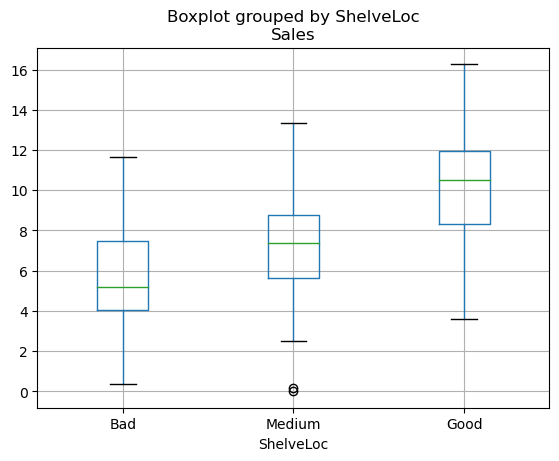

In [7]:
# Sort the DataFrame based on the order
shelve_loc_order = ['Bad', 'Medium', 'Good']
carset['ShelveLoc'] = pd.Categorical(carset['ShelveLoc'], categories=shelve_loc_order, ordered=True)
carset = carset.sort_values(by='ShelveLoc')


# Plot the boxplot
# TO DO ########################
boxplot = carset.boxplot(column=['Sales'],by='ShelveLoc')

  
##########################################

We will start to prepare the dataset for developing our classifiers. Given that in this dataset the output variable, *Sales*, is numeric, we will bin this variable into two groups based on whether or not the sales are greater than 8 (*Sales*$>8$)

Creating a new column called *High_Sales*, assigning a value of 'Yes' for locations with sales exceeding 8, and 'No' for those with sales equal to or less than 8.

In [8]:

##creating a new column and then displaying the first five columns from the dataset
carset['High_Sales'] = np.where(carset['Sales']>8, "Yes", "No")
carset.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High_Sales
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
307,5.90,138,92,0,13,120,Bad,61,12,Yes,No,No
246,6.90,120,56,20,266,90,Bad,78,18,Yes,Yes,No
309,11.18,131,111,13,33,80,Bad,68,18,Yes,Yes,Yes
311,6.15,146,68,12,328,132,Bad,51,14,Yes,Yes,No


 Dropping the column sales.

In [9]:
carset.drop( ['Sales' ], axis=1,inplace=True ) 
carset.head()


,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High_Sales
0,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
307,138,92,0,13,120,Bad,61,12,Yes,No,No
246,120,56,20,266,90,Bad,78,18,Yes,Yes,No
309,131,111,13,33,80,Bad,68,18,Yes,Yes,Yes
311,146,68,12,328,132,Bad,51,14,Yes,Yes,No


We can use the method carset.info() to visualize the type of the new colums

In [10]:
carset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   CompPrice    400 non-null    int64   
 1   Income       400 non-null    int64   
 2   Advertising  400 non-null    int64   
 3   Population   400 non-null    int64   
 4   Price        400 non-null    int64   
 5   ShelveLoc    400 non-null    category
 6   Age          400 non-null    int64   
 7   Education    400 non-null    int64   
 8   Urban        400 non-null    object  
 9   US           400 non-null    object  
 10  High_Sales   400 non-null    object  
dtypes: category(1), int64(7), object(3)
memory usage: 34.9+ KB


As we will need to know which features are quantitative and qualitative for building the classifiers, let's create a dictionary that uses the feature name as the key and if such a feature is numerical (True or False) as the value. We can know the type of each column using carset.dtypes.

In [11]:
typeFeat = carset.dtypes
print(typeFeat)

dictFeatType = {}
for idxFeat in range( len( typeFeat ) ):
    dictFeatType[ carset.columns[idxFeat] ] = typeFeat[idxFeat]== 'int64'  
    
dictFeatType

CompPrice         int64
Income            int64
Advertising       int64
Population        int64
Price             int64
ShelveLoc      category
Age               int64
Education         int64
Urban            object
US               object
High_Sales       object
dtype: object


{'CompPrice': True,
 'Income': True,
 'Advertising': True,
 'Population': True,
 'Price': True,
 'ShelveLoc': False,
 'Age': True,
 'Education': True,
 'Urban': False,
 'US': False,
 'High_Sales': False}

## Splitting data into training and test sets
We will split our dataset into two sets: 80% for the training set and 20% for the test set. The training set will be used to develop the classifiers and the test to evaluate the accuracy of those models. 

To split into training and test set, we will use Python's inbuilt function StratifiedShuffleSplit (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html). The StratifiedShuffleSplit method ensures that both the training and test set has the same proportion of the response variable.

In [12]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(carset, carset['High_Sales'] )):
    X_train, X_test = carset.iloc[ train_index ][ carset.columns[:-1] ], carset.iloc[ test_index ][ carset.columns[:-1] ]
    y_train, y_test = carset.iloc[ train_index ]['High_Sales'], carset.iloc[ test_index ]['High_Sales']

print('Shape of train set')
print(X_train.shape, y_train.shape)

print('Shape of test set')
print(X_test.shape, y_test.shape)

Shape of train set
(320, 10) (320,)
Shape of test set
(80, 10) (80,)


Checking class proportions. We can see that both sets have around 60% and 40% for the 'No' and 'Yes' classes, respectively.

In [13]:
print('Class proportion for training set')
print( 100*y_train.value_counts( )/len( y_train) )
print('Class proportion for test set')
print( 100*y_test.value_counts( )/len( y_test) )
print(X_train.columns)

Class proportion for training set
High_Sales
No     59.0625
Yes    40.9375
Name: count, dtype: float64
Class proportion for test set
High_Sales
No     58.75
Yes    41.25
Name: count, dtype: float64
Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')


## Decision Tree Classifier

We will build our decision tree from scratch. We know that a tree is a recursive structure in which each node can have one or more children. So, we are going to define a class called 'Node', which can reference other instances from the node class. This class also will have the following attributes:
- 'feature': The name of the feature stored in the node
- 'isFetNum': Indicate if the feature is numeric (yes:True, no:False)
- 'value': For numerical features, the mean value of the feature. For categorical variables, the category values 
- 'label': The majority class proportion for the node



In [14]:
class Node:
    def __init__(self, feature, value, isFetNum, label , children=None  ):
        self.feature = feature  
        self.value = value
        self.isFetNum = isFetNum
        
        self.label = label
        self.children = children  

As we discussed in class, we need to define a function to measure the purity. To this aim, we are going to use gini index, which is defined as:

$ G_{i,j} = \sum_{k}^{K} p_{k} \cdot (1-p_{k})$,

where $p_{k}$ is the proportion of $k-th$ class at the $j-th$ children of the $i-th$ node.

The gini index need to be calculated for each children. Then, the gain for the specific feature is computed as:

$Gain = G_{i} - \sum_{j}^{C} \frac{N_{j} }{N_i} \cdot G_{i,j} $,

where $N_{j}$ is the total samples in the $j-th$ children, and  $N_{i}$ the total samples in the $i-th$ node.

 Let's do these calculations in different steps.

First, complete the function giniFun, which receives a vector of classes as an argument. You will need to iterate over all the possible values of classes to determine the proportion of each class ($p_{k}=N_{k}/N$). Using the proportion of the classes, compute the Gini equation.

In Python, you can obtain the unique classes using the command: ``uniqueClass = classes.unique()``

In [15]:
def giniFun( classes ):
    
    
    
    #for retriving all the unique classes from the 'classes' vector
    uniqueClass = classes.unique()
    
    #converting it into a list
    list1 = list( uniqueClass)
    
    
    totalSamples = len( classes )
    giniValue = 0
   
    for idxClass in range( len(list1)):
        p = np.sum(classes == list1[idxClass] )/totalSamples
        
        giniValue += p**2
        
    return 1 - giniValue
    


The `giniFun` calculates the gini for only one node. Now, we need to compute the gini index for each child's node and accumulate them.

The input `childrenGroupClass` is a list of the children of the node. You need to iterate over the children node and calculate the `giniFun` for each child. To aggregate the gini index value of all the children, you will need to multiply the gini index with the proportion of samples in that children ($\sum_{j}^{C} \frac{N_{j} }{N_i} \cdot G_{i,j} $)

In [16]:
def calculateGiniIndexChildren( childrenGroupClass  ):
    
    totalSamples = 0
    gini = 0 #gini of individual node from children
    childrenGini = 0 #sum of all the children gini indices will be stored here
    
    #TO DO #####################
    # use this to iterate over the child: 
    for child in childrenGroupClass:
    #length of all children are added to totalSamples
         totalSamples += len(child)
            
            
    #print("totalsamples",totalSamples)   
    for child in childrenGroupClass:
    #proportion of samples in a particular children
        proportion = len(child)/totalSamples
        
        #print(proportion)
        #child node is converted into pandas series in case it's not
        vctr = pd.Series(child)
        #print(giniFun(vctr))
        gini = giniFun(vctr)
        
        #all the individual ginis are multiplied by proportion and then summed into childrenGini
        childrenGini += gini * proportion
        
        
 
    ########################################
    #return gini
    return childrenGini


Now that you calculate the accumulated gain of the children, it is time to calculate the gain in the Gini index. For this, you need to calculate the Gini index of the node. Then, you will need to call `calculateGiniIndexChildren( childrenGroupClass  )`. Finally, subtract the two quantities.

In [17]:
def gainGiniIndex( allLabels, childrenGroupClass ):
    #TO DO #####################
    #first parameter i.e parent node is converted into pandas series
    vctr1 = pd.Series(allLabels) 
    #gini for parent is calculated
    giniAll = giniFun(vctr1)
    #second parameter i.e 2-D array of children nodes is converted into pandas series
    vctr2= pd.Series(childrenGroupClass) 
    #children Gain is calculated using the calculateGiniIndexChildren()
    childrenGain = calculateGiniIndexChildren(vctr2)
    
  
    ########################################
    return giniAll - childrenGain

 Now, we will use the developed functions to build the decision tree. We will complete the part corresponding to the feature selection. Remember that we need to use the feature whose gain index is the maximum.

As we have two types of features (numerical and categorical), the process for calculating the gain index will be different for each type.
- Numerical features. First, calculate the mean value of the samples of the node. You need to create two children. The left child will correspond to those elements whose feature value is lower than or equal to the mean. The right children will correspond to those elements whose feature value is greater than the mean. The children need to be allocated into a list, and the `gainGiniIndex` will need to be called.

- Categorical features. First, identify the different categories for the features using `samples[col].unique().` You will need to iterate over the possible values and select the subsample that corresponds to the category. Add each subsample to the children's list. Then, called the `gainGiniIndex` using the children list. 


Once you calculate the gain for each feature, select the feature that obtained the highest gain. This will be used to split the node.

The following function make the prediction using the built tree.

In [18]:
columns = list(X_train.columns)
features = columns.copy()
selected = []

def buildTree(samples, labels, features):
    bestFeat = None
    bestGain = -1
    
    #iterate over all the features
    for col in features:

        # Check if the feature is numerical or categorical
        if dictFeatType[col]:
            #Numerical features
            list_using_loc = samples.loc[:, col]
            
            ########### TO DO ##########################
            # calculate the mean
            
            mean = list_using_loc.mean()
             #define the left and right children
            leftChild = []
            rightChild = []
            
            n=0
            
            for child in list_using_loc :
                 # left for <= mean
                if child <= mean:
                    leftChild.append(labels.iloc[n] )
                #right for > mean
                else:
                    rightChild.append(labels.iloc[n])
                    
                n+=1

            #add children into a list
            
            both = []
            both.append(leftChild)
            both.append(rightChild)
            
            
            #call the gainFunction
            Gain = gainGiniIndex(labels, both)
            
            if Gain > bestGain:
                bestGain = Gain
                bestFeat = col
                
                
                
                
                
        else:
            #categorical
            ########### TO DO ##########################
            # find unique categories of the feat (.unique())
            categories = samples[col].unique()
            samp = samples.loc[:, col]
            
            children = []
            
            #iterate for each 
            for cat in categories:           
                selected = []
                r=0
                
                for j in samp:
                    #select those sumples equal (==) to the cat
                    if j == cat:
                         selected.append(labels.iloc[r])
                    r+=1
                #adding to the children list
                children.append(selected)

            #call gain function
            Gain = gainGiniIndex(labels, children)
            ##########################

        ########### TO DO ##########################
        #update bestGain and bestFeat in case the gain is greater than the current value
        
            if Gain > bestGain:
                bestGain = Gain
                bestFeat = col

    # removing the selected feature from the features list 
    if bestFeat in features:      
        features.remove(bestFeat)

    ################################################################################################################
    # This part is the recursive call to build the tree
    # please do not modify ##########################
    ### split ###
    modeValue = labels.mode()
    label = modeValue[0]        
    if dictFeatType[bestFeat]:
        #This is a numerical feature
        isFetNum = True
        meanValue = samples[bestFeat].mean()
        node = Node(bestFeat, meanValue, isFetNum, label )

        # We only split if the gain is greater than 0
        if bestGain > 0 and len(features)>0:
            leftSubgroup_x =  samples[ samples[bestFeat] <= meanValue ][features]
            leftSubgroup_y =  labels[ samples[bestFeat] <= meanValue ]
            left = buildTree( leftSubgroup_x, leftSubgroup_y, features.copy() )
            rightSubgroup_x = samples[ samples[bestFeat] > meanValue ][features]
            
            rightSubgroup_y = labels[ samples[bestFeat] > meanValue ]
            right = buildTree( rightSubgroup_x, rightSubgroup_y, features.copy()  )
            node.children = [left, right ]
    else:
        #This is a categorical feature
        isFetNum = False
        catValue = samples[bestFeat].unique()
        node = Node(bestFeat, catValue, isFetNum, label )
        # We only split if the gain is greater than 0
        
        if bestGain > 0 and len(features)>0:
            children = [ ]
            for cat in catValue:
                catGroup = samples[ samples[bestFeat] == cat ][features]
                catGroupLabel = labels[ samples[bestFeat] == cat ]
                child = buildTree( catGroup, catGroupLabel, features.copy() )
                children.append( child )
            node.children = children

    return node
        
myNode = buildTree( X_train, y_train, features )  

In [19]:
def predict(sample, node):
    
    if node.children == None :
        #case base. The node does not have children
        return node.label
    
    #Checking if the node holds a numerical or categorical feature
    if node.isFetNum: 
        #Numerical feature
        feature = node.feature
        value = node.value
    
        #checking which path to take
        # left child if lower than value
        if sample[ feature ]  <= value:
            label = predict(sample, node.children[0] )
            
        else:
            #right child
            label = predict(sample, node.children[1] )
    else:
        #categorical feature
        feature = node.feature
        values = node.value
        
        #iterate over the values
        for idxValue in range( len(values) ):
            #find that one that match the sample value
            if values[idxValue] == sample[ feature ]:
                label = predict(sample, node.children[idxValue] )
                
        
    return label

Calculate the accurcury on the X_train and X_test. Complete the `calculateAccuracy` which iterate over the samples and call the method. If the prediction is equals to the actual value, increase the variable `correctSamples`.

The expected output is: "Accuracy for training set:0.971875 and for test set:0.7125"

In [20]:
def calculateAccuracy( dt, samples, labels ):
    correctSamples = 0

    for idx, row in samples.iterrows():
        #TO DO ####################
        #Node = buildTree( X_train, y_train, features) 
        predicted = predict(row,dt)
        actual = labels[idx]
        if predicted == actual:
            correctSamples += 1
             #########################

    return correctSamples/len( labels )


accuracyTrain = calculateAccuracy( myNode, X_train, y_train )

accuracyTest = calculateAccuracy( myNode, X_test, y_test )

print( "Accuracy for training set:{} and for test set:{}".format( accuracyTrain, accuracyTest) )

Accuracy for training set:0.971875 and for test set:0.7125


Now, let's see the effect of the cost complexity pruning for the prediction. We will need to calculate the number of leaf nodes in the tree, as well as to extract subtrees of the already built tree. The following two blocks perform such tasks.

In [21]:
def totalLeaf( node):
    
    if node.children is None :
        return 1
    

    
    totalL = 0
    for child in node.children:
        
        totalL+= totalLeaf( child )
    
    return  totalL
        
totalLeaf(myNode)

110

In [22]:
def cutPerLevel( node, level, maxLevel ):
    
    if level == maxLevel:
        node.children = None
    else:
        if not node.children is None:
        
            for child in node.children:
                #recursive step
                cutPerLevel( child, level+1, maxLevel )
                

allTrees = [ ]
leavesPerTree = [ ]
accuracyPerTree = [ ]
levels = 10
for level in range(levels):
    print('Tree with '+str(level)+" levels")
    features  = columns.copy()
    dt_l =  buildTree( X_train, y_train, features )   
    cutPerLevel( dt_l, 0, level )
    
    leaves = totalLeaf( dt_l )
    accTree  = calculateAccuracy( dt_l, X_train, y_train )
    print( 'total leaves:{} accuracy train:{}'.format( leaves, accTree ) )
    allTrees.append( dt_l )
    leavesPerTree.append( leaves )
    accuracyPerTree.append( accTree )





Tree with 0 levels
total leaves:1 accuracy train:0.590625
Tree with 1 levels
total leaves:3 accuracy train:0.7125
Tree with 2 levels
total leaves:6 accuracy train:0.740625
Tree with 3 levels
total leaves:12 accuracy train:0.775
Tree with 4 levels
total leaves:22 accuracy train:0.803125
Tree with 5 levels
total leaves:38 accuracy train:0.84375
Tree with 6 levels
total leaves:57 accuracy train:0.878125
Tree with 7 levels
total leaves:79 accuracy train:0.9125
Tree with 8 levels
total leaves:98 accuracy train:0.95
Tree with 9 levels
total leaves:110 accuracy train:0.971875


Now, we need to implement the complexity pruning routine. Use the lists `accuracyPerTree` and `leavesPerTree` for this calculation. These two lists contain the accuracy and leaves for some substrees, respectively. 

For each possible value of $\alpha$, you need to find the subtree that obtains the lowest complexity cost, which is calculated as:

$ CP_{t} = \sum_{m=1}^{|T|} E_{m} + \alpha \cdot |T| $

where |T| is the number of leaves of the tree, and $E$ is error that is calculated as 1-accuracy.



In [23]:
alphas = np.linspace(0, 0.02, 100)
trainAccuracy = np.empty( len(alphas) )
testAccuracy = np.empty( len(alphas) )


for idxAlpha in range(len(alphas)):
    alpha = alphas[idxAlpha]
    bestTreeIdx = 0
    bestScore = 1000
    
    
    for idxTree in range(len(allTrees)):
        
        
        tree = allTrees[idxTree]
        accuracyTrain = accuracyPerTree[idxTree]
        numLeaves = leavesPerTree[idxTree]
        
        
        ## TO DO ##########################
        
        # error is  1 - accuracy
        error = 1 - accuracyTrain
        
        
        #complexity cost
        score = np.sum(error) + (alpha * numLeaves)
        
        # Updating best score and tree index if current score is less
        
        if score < bestScore:
            bestScore = score
            bestTreeIdx = idxTree
            
        
        ##########################
        
    print( 'For alpha:{}, the best cp score is {} and the best tree has:{} leaves'.format(
        alpha, bestScore, leavesPerTree[bestTreeIdx] ) )
    
    trainAccuracy[ idxAlpha ]  = calculateAccuracy( allTrees[bestTreeIdx], X_train, y_train )
    
    testAccuracy[ idxAlpha ]  = calculateAccuracy( allTrees[bestTreeIdx], X_test, y_test )

For alpha:0.0, the best cp score is 0.028124999999999956 and the best tree has:110 leaves
For alpha:0.00020202020202020202, the best cp score is 0.05034722222222218 and the best tree has:110 leaves
For alpha:0.00040404040404040404, the best cp score is 0.07256944444444441 and the best tree has:110 leaves
For alpha:0.0006060606060606061, the best cp score is 0.09479166666666662 and the best tree has:110 leaves
For alpha:0.0008080808080808081, the best cp score is 0.11701388888888885 and the best tree has:110 leaves
For alpha:0.00101010101010101, the best cp score is 0.13923611111111106 and the best tree has:110 leaves
For alpha:0.0012121212121212121, the best cp score is 0.1614583333333333 and the best tree has:110 leaves
For alpha:0.0014141414141414141, the best cp score is 0.1836805555555555 and the best tree has:110 leaves
For alpha:0.0016161616161616162, the best cp score is 0.20590277777777774 and the best tree has:110 leaves
For alpha:0.0018181818181818182, the best cp score is 0.

The following block plot the training and test accuracy for each alpha.

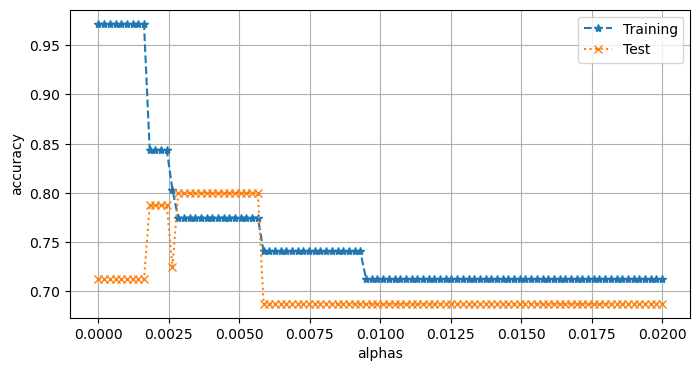

In [24]:
plt.figure(figsize=(8,4))
plt.plot( (alphas), trainAccuracy, '*--', label='Training')
plt.plot( (alphas), testAccuracy, 'x:', label='Test')

plt.xlabel('alphas')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

When hyperparameter alpha is in the range 0.0000 and 0.0025, the test accuracy is far less than training accuracy,(which suggests that our model was overfit in this range) the test accuracy abruptly starts increasing and training accracy starts decreasing for alpha = 0.0020.Both training and test sets intersect at alpha somewhere around 0.0027 with accuracy in the range 77 to 80 percent.
In the range for alpha 0.0025 and 0.0050,test accuracy remains constant at 80 % is a little higher than training.
After 0.0050,both of them decrease substantially.As alpha increases, there is a cost to having a big tree, so a smaller subtree is selected which reduces accuracy.

So far, we have implemented the decision tree from scratch. In practice, we do not have to do this at each time. We can take advantage of the built-in functions. Specifically, we can use the class Decision Tree from sklearn (https://scikit-learn.org/stable/modules/tree.html)

In order to use the in-built decision tree, we need to convert the categorical features, which have string values, to numerical values. We can do that using `LabelEncoder`, as is shown in the block. This will convert the values of the columns 'ShelveLoc', 'Urban', 'US' into a number for each category.

Use the `X_train_encoded` to train a decision tree. You first, need to define an object from that class (`clf = tree.DecisionTreeClassifier(random_state=0`). Then use the method fit as shown in the class documentation (https://scikit-learn.org/stable/modules/tree.html)

Once build the decision tree, use the method `predict` to estimate the class from the `X_test_encoded`

In [25]:
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics


colCat = ['ShelveLoc', 'Urban', 'US']

le = LabelEncoder()
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for c in colCat:
    X_train_encoded[ c ] = le.fit_transform( X_train[ c ] ) 
    X_test_encoded[ c ] = le.transform( X_test[ c ] ) 

    
    
#######################################################
######################## TO DO ########################
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train_encoded,y_train)
#tree.plot_tree(clf)
y_pred = clf.predict(X_test_encoded)
accTest = metrics.accuracy_score(y_test, y_pred)


###########################################

print('Test accuracy is ', accTest)

Test accuracy is  0.725


# KNN

Now, we will use kNN to check the performance on the same dataset.

As kNN uses the Euclidean distance to find the nearest neighbors. We need to calculate the categorical variables into numbers. The best practice is to convert each category into one-hot-encoded variable, in which each category value is converted into a column. A value of 1 in that column indicates the sample of that value. For example, let's assume we have this small data, and we want to convert the feature color into a one-hot-encoded variable.

| Fruit  | Weight  | Color |
|----------|----------|----------|
| Apple | 182 | 'red' |
| Banana | 120 | 'yellow' |
| Apple | 177  | 'red' |

So, the column color we will convert into two columns: one for red and the second one for yellow.


| Fruit  | Weight  | red | yellow |
|----------|----------|----------|---------|
| Apple | 182 | 1 |0 |
| Banana | 120 | 0 |1 |
| Apple | 177  | 1 |0 |

The block below performs the transformation

In [26]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

numCols = [c for c in X_train.columns if c not in colCat] 

#hstack function stacks the two arrays in arguments as a one 2-dimentional array
Xtrain = np.hstack([ X_train[numCols ].to_numpy(), #converted the pd dataframe into numpy 2-D array
                    enc.fit_transform( X_train[ colCat ] ).toarray() ])

Xtest = np.hstack([ X_test[numCols].to_numpy(), 
                    enc.transform( X_test[ colCat ] ).toarray() ])



yTrain = y_train.to_numpy()
yTest = y_test.to_numpy()

print( Xtrain.shape, yTrain.shape, Xtest.shape , yTest.shape )

(320, 14) (320,) (80, 14) (80,)


 Another important transformation for the kNN is to normalize the numerical variables. In the next code, you need to normalize the features. For each feature, you need to calculate the mean and std using the `Xtrain`. Remember that the normalized is calculated as follows:
$ z = \frac{x-\mu}{\sigma} $.

Complete the function that transforms a vector of values into a normalized vector.

In [27]:
def normalize(x_values, mean, std):
    #TO DO #######
    
    z = (x_values - mean) / std
    
    ############
    return z

Now we have to iterte over the numerical columns, and call the normalize function for the training and test sets.

In [28]:
for iCol in range(len( numCols) ):
    meanValue = np.mean( Xtrain[ :,iCol ] ) 
    stdValue = np.std( Xtrain[ :,iCol ] ) 
    
  
    Xtrain[ :,iCol ] = normalize(Xtrain[ :,iCol ], meanValue, stdValue)
    Xtest[ :,iCol ] = normalize(Xtest[ :,iCol ], meanValue, stdValue)

Write the function that calculates the Euclidean distance between two points.

$
d(x, new\_point) = \sum_{j=1}^{p} = (x_j, new\_point_j)^2
$

In [29]:

def ecludianDistance( x, new_point):
    
    x, new_point = np.array(x),np.array(new_point)
    
    #TO DO ##############
    sum = 0
    for i in range(len(x)):
        sum += (x[i] - new_point[i])**2
    
    d = np.sqrt(sum)
    ##############
    return d

After implementing the distance function, we need a function that iterates for each training sample and calculates the distance to the new point. The function returns the distance between the new point and each sample.

In [30]:
def calculateDistance( new_point, samples  ):
    
    distances = np.empty( samples.shape[ 0 ] )
    #TO DO ##############
    for i, sample in enumerate(samples):
        
        distance = ecludianDistance(sample, new_point)
        distances[i] = distance
        
    
    ##############
    
    return distances

Implement the `predictKNN` that receives as input $k$. You need to call the function `calculateDistance` for each point. Then, find the closet k points. Take the majority of labels from these samples as the prediction value.

In [31]:
from collections import Counter
def predictKNN( k, new_point, samples, labels):
    
    #TO DO ##############
    distances = calculateDistance(new_point, samples)
    
    k_indices = np.argsort(distances)[:k]
    k_nearest_labels = [labels[i] for i in k_indices]
    
     
    mode = Counter(k_nearest_labels).most_common()
    
   


    ########################################
    return mode[0][0]

Now, implement the function that calculates the accuracy based on the predicted value.

In [32]:
def calculateKNN( k, dataTrain, labelTrain, dataTest, labelTest ):
    acc = 0
    for idx in range( dataTest.shape[ 0 ] ):
        
        #TO DO ##############
        pred = predictKNN( k, dataTest[idx], dataTrain, labelTrain)
        
        
        

        #############################################
        if pred == labelTest[ idx ]:
            acc += 1

    accRate = acc/dataTest.shape[ 0 ]

    return accRate

We now use different values to evaluate the performance of the kNN.

In [33]:
ks  = [1,3,5,7,9,11,21,33,55, len(yTrain) ]
trainAccuracyKnn = np.empty( len(ks) )
testAccuracyKnn = np.empty( len(ks) )

for idxK in range(len(ks)):
        
    trainAccuracyKnn[ idxK ]  = calculateKNN( ks[idxK], Xtrain, yTrain, Xtrain, yTrain )
    testAccuracyKnn[ idxK ]  = calculateKNN( ks[idxK],  Xtrain, yTrain, Xtest, yTest)


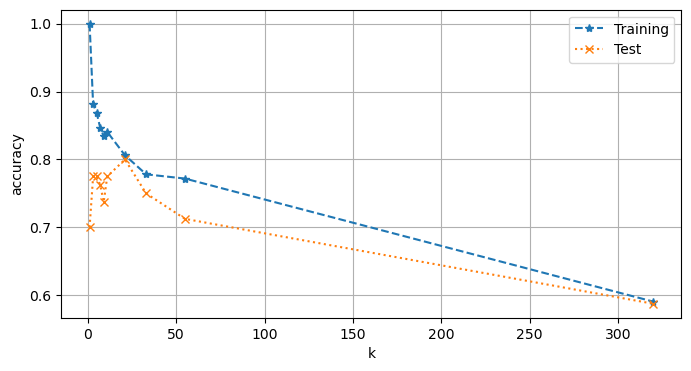

In [34]:
plt.figure(figsize=(8,4))
plt.plot( ks, trainAccuracyKnn, '*--', label='Training')
plt.plot( ks, testAccuracyKnn, 'x:', label='Test')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.show()

    
The model showed better performance on the training set as compared to the test set. So we can conclude it's overfitted, it is able to predict training data with very good accuracy but not so well with test data.
Also, with the increase in value of k,we see a decline in accuracy for both training and test data.So, we can also state that with the increase in number of neighbours, it's overall accuracy decreases for both traning and test data as there is an increment in irrelevant data points.There is one more interesting thing I found in figure,we hit a point in the range 0 to 50 where the training and test accuracy are similar which is 0.8. This is the point where we can say that the model was most successful in balancing bias and variance.


Similar to the decision tree, Python accounts with a function for kNN. Check the documentation: https://scikit-learn.org/stable/modules/neighbors.html to build the KNeighborsClassifier using k=13 on Xtrain. Calculate the test using Xtest.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


###### TO DO #################################
#KNeighborsClassifier instance created with k = 13
knn = KNeighborsClassifier(n_neighbors=13)
#model is trained using the training data
knn.fit(Xtrain, yTrain)

y_pred = knn.predict(Xtest)
accTest = accuracy_score(yTest, y_pred)


#################################
print( 'Accuracy test is', accTest)

Accuracy test is 0.8125
